# 3D Protein Pose Recovery - Robustness to Perturbations

Through the following model, we consider that a cryo-EM measurement (i.e. 2D projection) $\mathbf{y}_i \in \mathbb{R}^{M}$ is acquired through
\begin{equation}
\label{eq:linear-forward-model}
\mathbf{y}_i={\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x+\mathbf n,
\end{equation}
where $\mathbf x \in \mathbb{R}^{V}$ is the unknown 3D density map [*DiMaio et al.*](https://academic.oup.com/bioinformatics/article/23/21/2851/374177) (Coulomb potential). The operator $\mathbf P_{\theta_i}: \mathbb R^V \to \mathbb R^M$ is the projection along the 3D pose $\theta_i$ (i.e., the x-ray transform). The operator $\mathbf S_\mathbf{t}: \mathbb R^M \to \mathbb R^M$ is a shift of the projection by $\mathbf{t}=(t_1, t_2)$. The convolution operator $\mathbf {C}_{\boldsymbol\varphi}: \mathbb R^M \to \mathbb R^M$ models the microscope contrast transfer function (CTF) with parameters $\boldsymbol\varphi=(d_1, d_2, \alpha_{\rm ast})$, that are, respectively, the defocus-major, the defocus-minor and the angle of astigmatism. Finally, $\mathbf n \in \mathbb{R}^{M}$ represents an additive noise. Our goal is then to recover the angles $\theta_i$ from every projection $\mathbf y_i$. 

Testing the **faithfulness** of $\mathbf H_{\phi}$. We are only using one protein 3D volume $\mathbf x$ and the set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$ as well as all the other operators (noise $\mathbf n$, CTF $\mathbf C_\varphi$, shift $\mathbf S_{\mathbf t}$) specified in the equation above. 

The 2D projection set $\{\mathbf y_i\}$ is then split into disjoint training $\{\mathbf y_{i}^{train}\}$ and test $\{\mathbf y_{i}^{test}\}$ sets.


  $\mathbf x \rightarrow \{\mathbf y_i\} = \{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x+\mathbf n\} = \{\mathbf H_\phi \mathbf x+\mathbf n\} \implies \{\mathbf y_{i}^{train}\} \cup \{\mathbf y_{i}^{test}\} = \{\mathbf y_i\}  \land \{\mathbf y_{i}^{train}\} \cap \{\mathbf y_{i}^{test}\} = \emptyset$

In [1]:
import sys
sys.path.append("..") 
from cryoem.projections import generate_2D_projections
from cryoem.plots import plot_projection, plot_detector_pixels, plot_angles_count
from cryoem.preprocessing import preprocessing, train_val_test_split
from cryoem.distance_estimation import train_distance_estimation
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl
from cryoem.conversions import quaternion2euler
import matplotlib.pyplot as plt
from cryoem.conversions import d_q, euler2quaternion
from cryoem.reconstruction import reconstruct
from cryoem.plots import plot_dP_dQ
import h5py
import ipyvolume as ipv
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib 
tf.__version__

'2.0.0'

In [2]:
!echo $CUDA_VISIBLE_DEVICES

2


In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12356804506523963172
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4661119972007702325
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18015511255629156000
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11329617920
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 15216981913850555798
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:da:00.0, compute capability: 3.5"
]


## (1) Generate Sythetic Data

In [4]:
DATA_DIR        = "../data"
RESULTS_DIR     = "/mnt/scratch/students"

In [5]:
PROTEIN         = "5j0n"

PROJECTIONS_NUM = 5000
INPUT_FILE      = f"{PROTEIN}.mrc"
ANGLE_COVERAGE  = [2.0, 1.0, 0.5]
ANGLE_SHIFT     = [0., 0., 0.]
OUTPUT_FILE     = f"{PROTEIN}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5"

In [6]:
# generate sythetic data - 2D projections and their corresponding orientations from a given 3D protein
generate_2D_projections(input_file_path=f"{DATA_DIR}/{INPUT_FILE}", 
                        ProjNber=PROJECTIONS_NUM,
                        AngCoverage=ANGLE_COVERAGE,
                        AngShift=ANGLE_SHIFT,
                        angles_gen_mode="uniform_angles",
                        output_file_name=f"{RESULTS_DIR}/{OUTPUT_FILE}")

* Loading the dataset *

Projections: (5000, 116, 116)
Angles: (5000, 3)



In [6]:
f"{RESULTS_DIR}/{OUTPUT_FILE}"

'/mnt/scratch/students/5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift2.0,1.0,0.5.h5'

In [6]:
# read stored data for further processing
data = h5py.File(f"{RESULTS_DIR}/{OUTPUT_FILE}", 'r')
projections = data['Projections']
projections_original = data['Projections']
angles_true = np.array(data['Angles'])

print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images


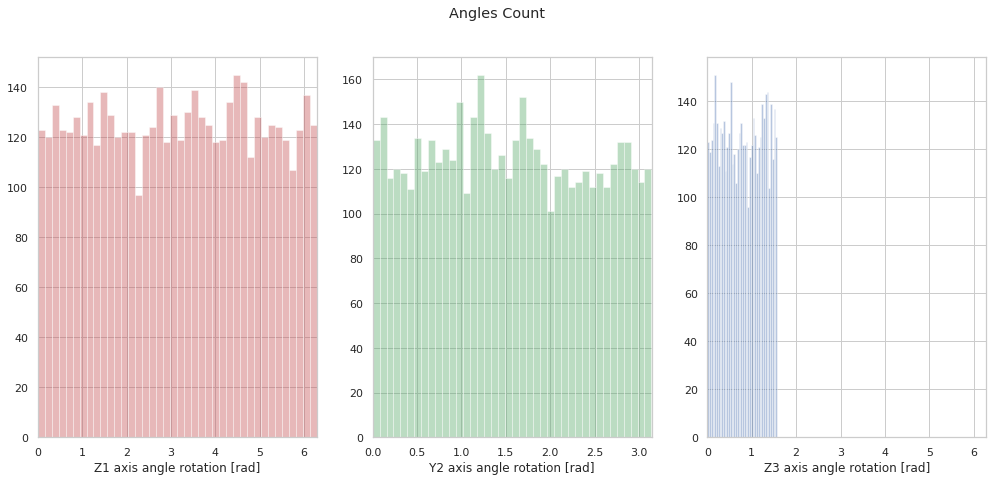

In [7]:
plot_angles_count(angles_true)

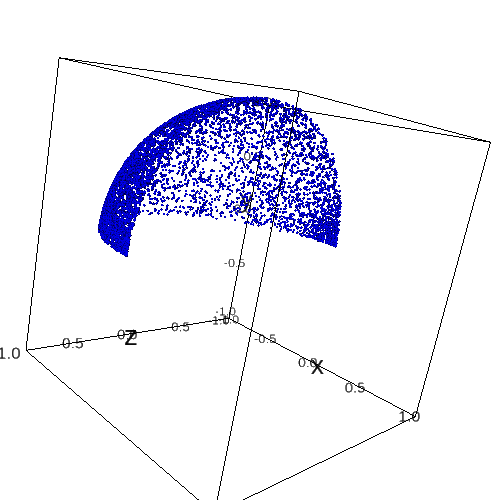

In [7]:
plot_detector_pixels(angles_true)

In [8]:
ipv.screenshot()

Output()

## (2) Preprocessing Data

In [7]:
NOISY_VAR = 10
TRANSLATION = 5

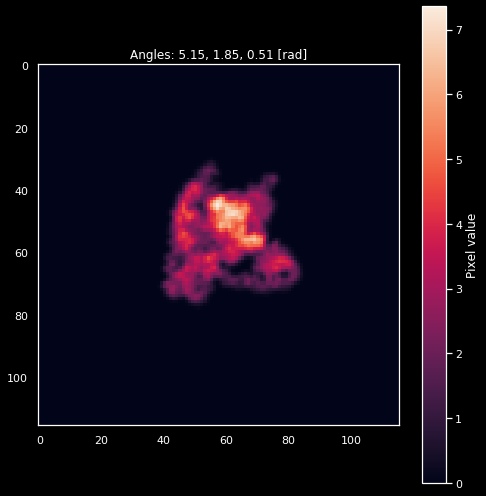

In [8]:
plot_projection(projections[0], angles=angles_true[0])

In [9]:
projections = preprocessing(projections, noise_var=NOISY_VAR, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels="gray")

--- Preprocessing projections ---
Image rescaled: from dimension 116 to 128 for MobileNet
Noise:
Variance=10
Translation:
left_limit=-5, peak_limit=0, right_limit=5
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 0.262 | Std: 3.323
	Min:  -17.692 | Max: 25.125
	Mean: 0.000 | Std: 1.000
	Min:  -5.403 | Max: 7.482


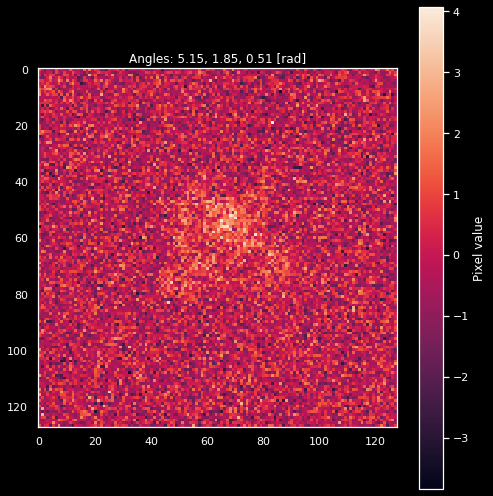

In [10]:
plot_projection(projections[0], angles=angles_true[0])

## (3) Distance Learning

In [11]:
DE_LOGS_DIR = f"{RESULTS_DIR}/distance_estimation"
DE_DESCRIPTION = "full_pipeline_test"

In [12]:
train_idx, val_idx, test_idx, train_pairs_num, val_pairs_num = train_val_test_split(PROJECTIONS_NUM, test_size=0.33, val_size=0.25, train_percent=0.01, val_percent=0.01)

TRAIN: 0.67 x 0.75 = 0.50 =>  2512 imgs => max pairs:    6310144   |   63101
TEST :               0.33 =>  1650 imgs => max pairs:    2722500   |   all
VAL  : 0.67 x 0.25 = 0.17 =>   838 imgs => max pairs:     702244   |   7022
Indices stored in ../data/train_val_test_indices.npz


In [ ]:
model, history = train_distance_estimation(X=projections, y=angles_true, 
                                           train_idx=train_idx, 
                                           val_idx=val_idx,
                                           epochs=50,
                                           batch_size=256,  #512 latest 
                                           learning_rate=1e-3, 
                                           limit_style="random", 
                                           path_logs_training=DE_LOGS_DIR, 
                                           training_description=DE_DESCRIPTION,
                                           training_steps=train_pairs_num,
                                           validation_steps=val_pairs_num, 
                                           plot=True,
                                           gpus=None)

Data created in 4.319854497909546 sec
Data created in 0.4799039363861084 sec
Input images shape (128, 128, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
_________________________________________________________________________________

In [13]:
# read stored model
model_filename = f"{DE_LOGS_DIR}/training/{DE_DESCRIPTION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [14]:
# learned distance function
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

<Figure size 432x288 with 0 Axes>

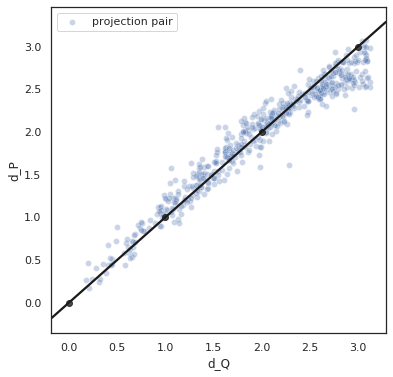

<Figure size 432x288 with 0 Axes>

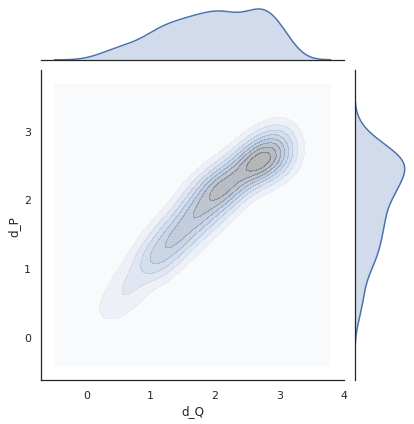

Variance = 0.1763898542314553
Min. angle recovery loss possible = 0.031052612354161645


In [15]:
# dP/dQ ratio plot
batch_size = 1024
idx1 = list(np.random.choice(test_idx, size=batch_size))
idx2 = list(np.random.choice(test_idx, size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [projections[i] for i in idx1]
p2 = [projections[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

plot_dP_dQ(dP_values, dQ_values, f"{DE_LOGS_DIR}/dPdQ.png");

## (4) Angle Recovery

In [16]:
from cryoem.angle_recovery import train_angle_recovery

In [17]:
AR_LOGS_DIR = f"{RESULTS_DIR}/angle_recovery"
AR_TRAINING_DESCRIPTION = "full_pipeline_test"

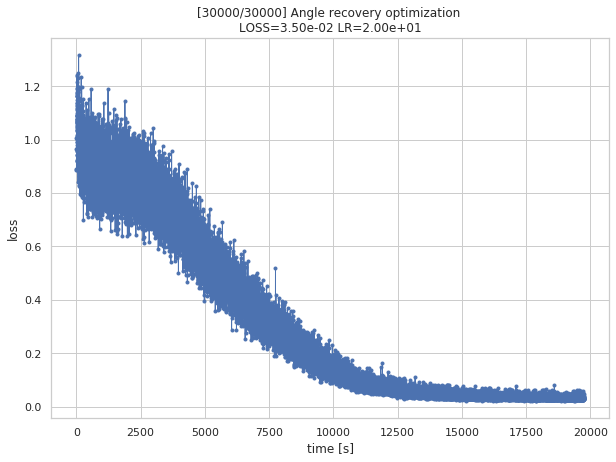

Shape of projections: (5000, 128, 128, 1)step 3000/30000 (1738s): loss = 7.74e-01
step 6000/30000 (3484s): loss = 6.16e-01
step 9000/30000 (5280s): loss = 4.51e-01
step 12000/30000 (7131s): loss = 3.09e-01
step 15000/30000 (9065s): loss = 1.56e-01
step 18000/30000 (11053s): loss = 4.70e-02
step 21000/30000 (13143s): loss = 3.66e-02
step 24000/30000 (15307s): loss = 3.39e-02
step 27000/30000 (17516s): loss = 2.94e-02
step 30000/30000 (19744s): loss = 3.41e-02



In [18]:
q_predicted, losses, q_all = train_angle_recovery(steps=30000, 
                                                 batch_size=256, 
                                                 in_data=projections[test_idx], 
                                                 distance_fn=d_p, 
                                                 learning_rate=20, 
                                                 limit_distance=np.pi,
                                                 low_ang_const=ANGLE_SHIFT,
                                                 high_ang_const=[sum(x) for x in zip(ANGLE_SHIFT, ANGLE_COVERAGE)],
                                                 file_name=f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}",
                                                 constraint=False)

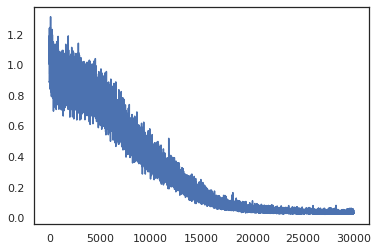

In [18]:
data = np.load(f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}.npz")
q_predicted, losses, collect_data = data['arr_0'], data['arr_1'], data['arr_2']
plt.plot(data["arr_1"])

In [19]:
angles_predicted = quaternion2euler(q_predicted)

## (5) Angle Alignment

m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [5.90579232 4.90953781 0.43064235 2.87584851 5.1046566  3.45437345] 
loss_first= 2.219353961877292 
trajectory_last= [-25.90880948 -34.58499133 -31.66381212 -15.19478413  -3.98895224
  44.97065965] 
loss_last= 0.1540686423091169


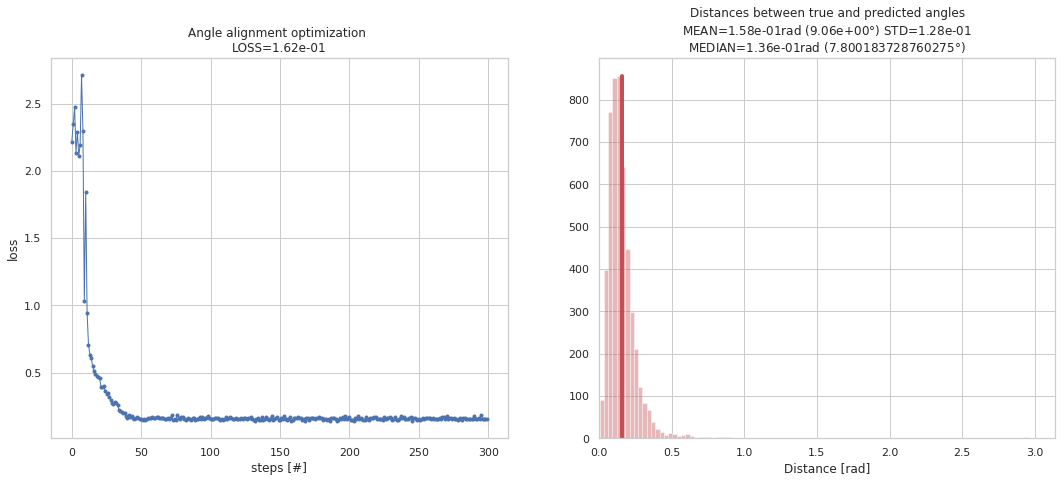

In [48]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=300, 
                                                                    batch_size=256, 
                                                                    optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true, 
                                                                    angles_predicted=angles_predicted,
                                                                    threshold=0.2)

In [70]:
from cryoem.plots import plot_rays
plot_rays(angles_true, range(10))

In [69]:
trajectory.shape

(301, 6)

In [21]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

## (6) Reconstruction

In [22]:
REC_LOGS_DIR = f"{RESULTS_DIR}/reconstruction"
REC_DESCRIPTION = "full_pipeline_test.mrc"

In [65]:
angles_predicted

<tf.Tensor: id=2689, shape=(5000, 3), dtype=float64, numpy=
array([[-0.8220658 ,  2.17608077, -2.52536372],
       [ 0.10819772,  1.41221318, -1.9608031 ],
       [-1.53205775,  1.75013525, -1.42568537],
       ...,
       [ 2.86390027,  0.40231196, -2.48562884],
       [-0.52721484,  0.98831919, -0.25038959],
       [-0.54727579,  1.97187616, -2.04459372]])>

In [66]:
angles_predicted_rotated

<tf.Tensor: id=3715234, shape=(5000, 3), dtype=float64, numpy=
array([[-1.2095774 ,  1.93953642,  0.46417235],
       [-2.41637719,  1.65122049,  0.09435763],
       [-1.62854121,  0.41662784,  0.76488605],
       ...,
       [ 0.24401382,  0.0737032 ,  1.63295391],
       [ 2.96905607,  0.09507884,  0.67494988],
       [-1.56681506,  1.65131866,  0.25850483]])>

In [67]:
angles_true

array([[5.14627844, 1.85293424, 0.50856176],
       [3.98451262, 1.73211982, 0.29329689],
       [4.57612295, 0.46516583, 0.89836796],
       ...,
       [1.42731449, 0.01055685, 0.5367215 ],
       [2.62138403, 0.12821249, 1.09304194],
       [4.64677858, 1.66052989, 0.31725796]])

In [124]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
from cryoem.rotation_matrices import RotationMatrix
import astra
import mrcfile
from pathlib import Path

def reconstruct(projections, angles, mrc_filename=None, overwrite=False):
    # Generate orientation vectors based on angles
    orientation_vectors   = RotationMatrix(angles)

    # Reshape projections correctly 
    projections1 = np.transpose(projections, (1, 0, 2))
    
    # Get projection dimension
    proj_size = projections1.shape[0]

    # Create projection 2D geometry in ASTRA
    proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
    #proj_geom = astra.create_proj_geom('parallel3d', 0.5, 0.5, proj_size, proj_size, orientation_vectors)
    projections_id = astra.data3d.create('-sino', proj_geom, projections1)

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
    reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)


    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= np.max(reconstruction)
    reconstruction = np.round(reconstruction * 255).astype(np.uint8)

    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(reconstruction_id)
    astra.data3d.delete(projections_id)


    # Save reconstruction to mrc file for chimera
    if mrc_filename:
        Path(mrc_filename).parent.mkdir(parents=True, exist_ok=True)
        with mrcfile.new(mrc_filename, overwrite=overwrite) as mrc:
            mrc.set_data(reconstruction)
        
    return reconstruction

def reconstruct_from_file(input_file, limit=3000, mrc_filename=None):
    data = np.load(f'data/{input_file}.npz')
    projections, angles = data["arr_0"].astype(np.float64)[:limit, :, :], data["arr_1"].astype(np.float64)[:limit, :]

    return reconstruct(projections, angles, mrc_filename)


In [125]:
reconstruction_pred = reconstruct(projections_original, angles_predicted, mrc_filename=False, overwrite=False)
reconstruction_pred = reconstruction_pred.astype(np.float)

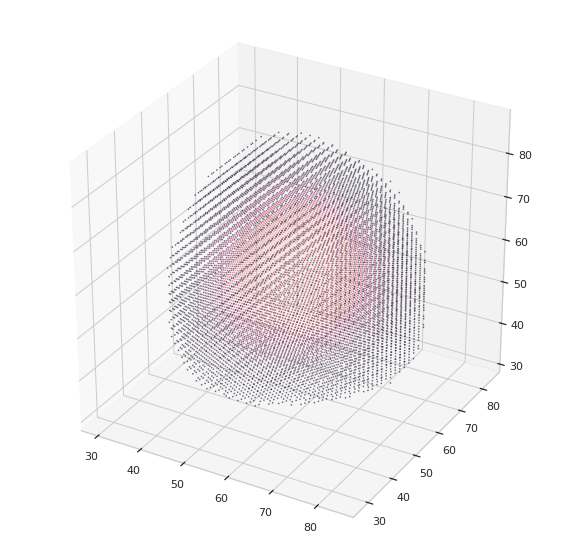

In [126]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume = reconstruction_pred 
volume[volume<50.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

In [57]:
reconstruction = reconstruct(projections_original, angles_predicted_rotated, mrc_filename=f"{REC_LOGS_DIR}/{REC_DESCRIPTION}", overwrite=True)
reconstruction = reconstruction.astype(np.float)

In [58]:
reconstruction_true = reconstruct(projections_original, angles_true, mrc_filename=False, overwrite=False)
reconstruction_true = reconstruction_true.astype(np.float)

/home/jbanjac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


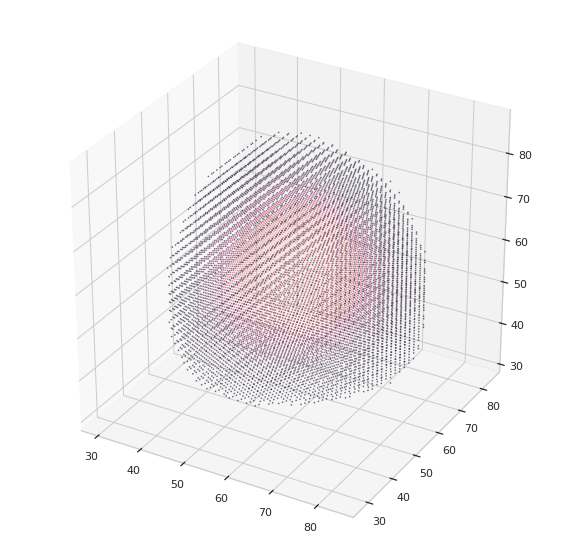

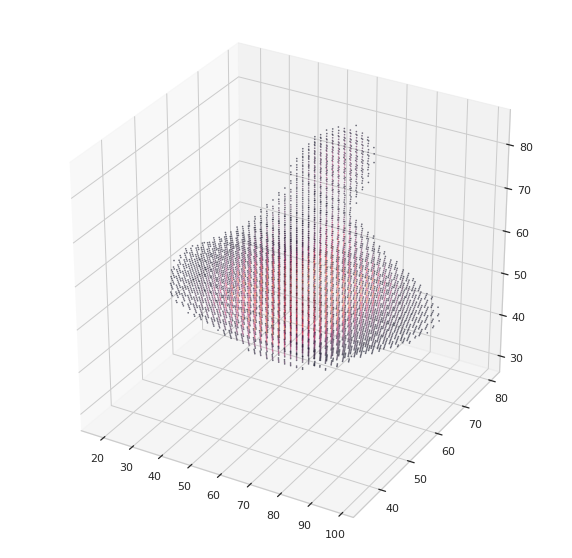

In [25]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume = reconstruction 
volume[volume<50.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

volume_true = reconstruction_true 
volume_true[volume_true<70.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

#fig = plt.figure(figsize = (10, 10))
#ax = fig.gca(projection='3d')
# ax.scatter(x_t.ravel(),
#            y_t.ravel(),
#            z_t.ravel(), alpha=0.5, s=0.5,
#            c=c_t)

/home/jbanjac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


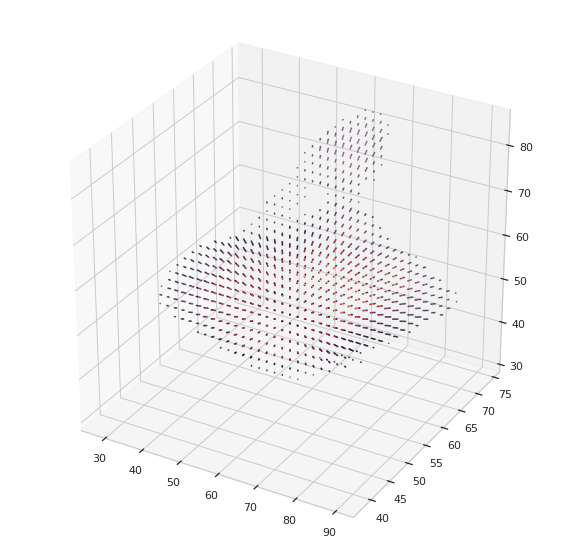

In [26]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume_true = reconstruction_true 
volume_true[volume_true<50.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x_t.ravel(),
           y_t.ravel(),
           z_t.ravel(), alpha=0.5, s=0.5,
           c=c_t)

/home/jbanjac/miniconda3/envs/protein_reconstruction/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jbanjac/miniconda3/envs/protein_reconstruction/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


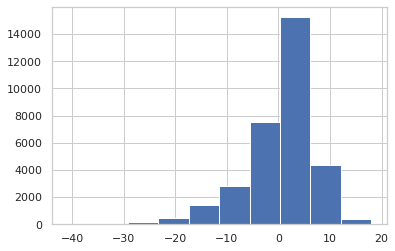

In [27]:
%matplotlib inline
plt.hist(reconstruction.ravel()-reconstruction_true.ravel());
plt.show()

In [28]:
reconstruction.ravel()[~np.isnan(reconstruction.ravel())]

array([50., 50., 50., ..., 50., 50., 50.])

In [29]:
reconstruction_true.ravel()[~np.isnan(reconstruction_true.ravel())]

array([70., 70., 72., ..., 71., 70., 70.])

In [30]:
volume_true.ravel()[~np.isnan(volume_true.ravel())]

array([70., 70., 72., ..., 71., 70., 70.])

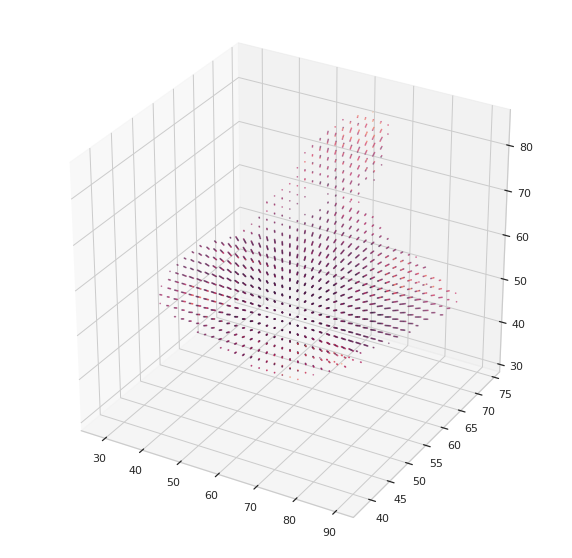

In [31]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume_true = reconstruction_true - reconstruction
#volume_true[volume_true<50.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x_t.ravel(),
           y_t.ravel(),
           z_t.ravel(), alpha=0.5, s=0.5,
           c=c_t)

In [43]:
volume_true = reconstruction_true - reconstruction

In [59]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(reconstruction_true.ravel(), reconstruction.ravel())
#np.mean_square_error(volume_true.ravel()[~np.isnan(volume_true.ravel())])
mse

3.7193221073024723